<a href="https://colab.research.BVHle.com/github/amanjain252002/Stock-Price-Prediction/blob/main/ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.BVHle.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
! pip install pmdarima

/Users/macbook/.zshenv:1: command not found: c
Defaulting to user installation because normal site-packages is not writeable


In [74]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [117]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
ACB = pd.read_csv("./Database/Pre_Processed_ACB.csv")
BIDV = pd.read_csv("./Database/Pre_Processed_BIDV.csv")
BVH = pd.read_csv("./Database/Pre_Processed_BVH.csv")
CTG = pd.read_csv("./Database/Pre_Processed_CTG.csv")
FPT = pd.read_csv("./Database/Pre_Processed_FPT.csv")

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series and help us understand if the series is stationary.

**Null Hypothesis**: The series has a unit root

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the Null Hypothesis, then the series is non-stationary.

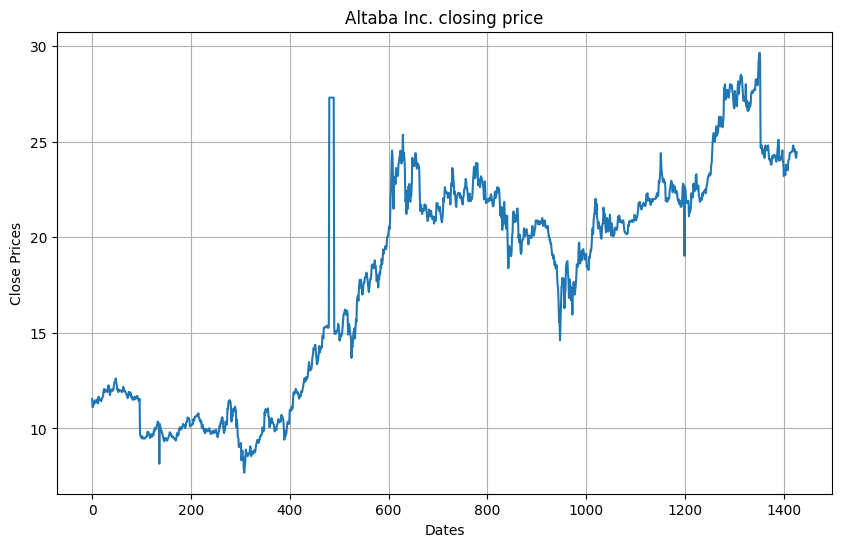

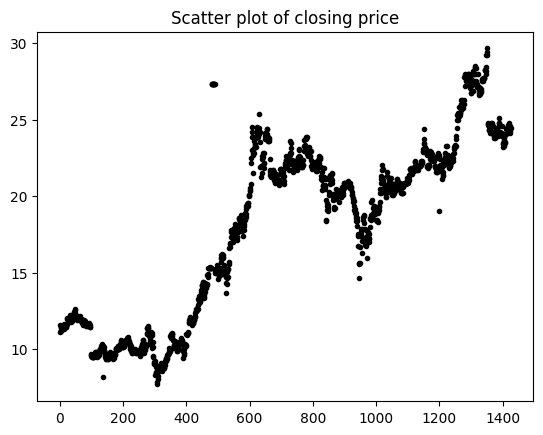

In [119]:
# Visualize the per day closing price of the stock.
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(ACB['Adj. Close'])
plt.title('Altaba Inc. closing price')
plt.show()

# Lets us plot the scatterplot:
df_close = ACB['Adj. Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

In [76]:
def Test_Stationarity(timeseries):
  result = adfuller(timeseries['Adj. Close'], autolag = 'AIC')
  print("Results of Dickey Fuller Test")
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Number of lags used: {result[2]}')
  print(f'Number of observations used: {result[3]}')
  for key, value in result[4].items():
    print(f'critical value ({key}): {value}')

#Apple

In [77]:
ACB.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02 00:00:00,11.703,11.693,11.416,11.544,1103106.0
1,2019-01-03 00:00:00,10.398,11.360,10.267,11.110,1956382.0
2,2019-01-04 00:00:00,11.070,11.413,11.052,11.189,2771983.0
3,2019-01-07 00:00:00,11.426,11.402,11.244,11.347,1305819.0
4,2019-01-08 00:00:00,12.414,12.378,11.235,11.268,846226.0


In [78]:
ACB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1427 non-null   object 
 1   Open        1427 non-null   float64
 2   High        1427 non-null   float64
 3   Low         1427 non-null   float64
 4   Adj. Close  1427 non-null   float64
 5   Volume      1427 non-null   float64
dtypes: float64(5), object(1)
memory usage: 67.0+ KB


In [79]:
# Change Dtype of Date column
ACB["Date"] = pd.to_datetime(ACB["Date"])

In [80]:
Test_Stationarity(ACB)

Results of Dickey Fuller Test
Test Statistics: -1.336210763429011
p-value: 0.6124473967936362
Number of lags used: 10
Number of observations used: 1416
critical value (1%): -3.434976549531161
critical value (5%): -2.86358329808087
critical value (10%): -2.5678578416363433


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

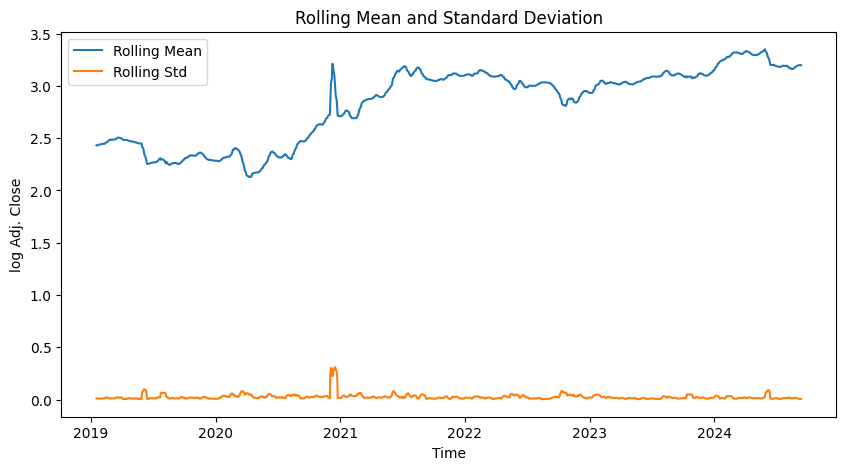

In [81]:
ACB['log Adj. Close'] = np.log(ACB['Adj. Close'])
ACB_log_moving_avg = ACB['log Adj. Close'].rolling(12).mean()
ACB_log_std = ACB['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(ACB['Date'], ACB_log_moving_avg, label = "Rolling Mean")
plt.plot(ACB['Date'], ACB_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

### Split the data into training and test set







(286, 7)


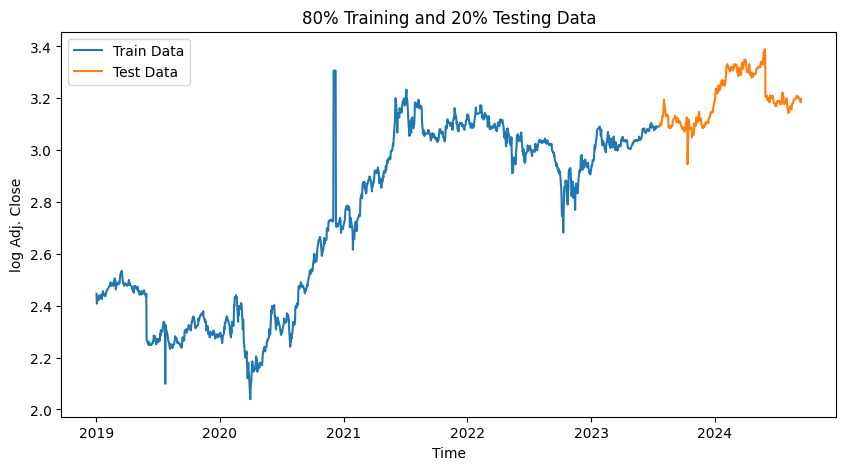

In [82]:
# Assuming ACB DataFrame is already defined and contains the necessary columns

# Calculate the cutoff index for 80% training and 20% testing
cutoff_index = int(len(ACB) * 0.8)

# Split the data into training and testing datasets
ACB_Train_Data = ACB.iloc[:cutoff_index]
ACB_Test_Data = ACB.iloc[cutoff_index:].reset_index(drop=True)

print(ACB_Test_Data.shape)
# Plot the train and test data
plt.figure(figsize=(10, 5))
plt.plot(ACB_Train_Data['Date'], ACB_Train_Data['log Adj. Close'], label='Train Data')
plt.plot(ACB_Test_Data['Date'], ACB_Test_Data['log Adj. Close'], label='Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.title('80% Training and 20% Testing Data')
plt.legend(loc='best')
plt.show()

###Modeling

In [102]:
ACB_Auto_ARIMA_Model = auto_arima(ACB_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(ACB_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1141
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2279.579
Date:                Sat, 14 Sep 2024   AIC                          -4557.158
Time:                        12:54:04   BIC                          -4552.119
Sample:                             0   HQIC                         -4555.255
                               - 1141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011   4.78e-06    224.277      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):           1446689.01
Prob(Q):                              0.20   Pr

In [107]:
from statsmodels.tsa.arima.model import ARIMA  # Correct import

# Fit ARIMA model
ACB_ARIMA_Model = ARIMA(ACB_Train_Data['log Adj. Close'], order=(1, 1, 0))
ACB_ARIMA_Model_Fit = ACB_ARIMA_Model.fit()

# Print the summary of the model
print(ACB_ARIMA_Model_Fit.summary())


                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1141
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2280.398
Date:                Sat, 14 Sep 2024   AIC                          -4554.796
Time:                        12:58:43   BIC                          -4539.679
Sample:                             0   HQIC                         -4549.087
                               - 1141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1069      1.443     -0.074      0.941      -2.934       2.720
ma.L1          0.0693      1.442      0.048      0.962      -2.757       2.895
sigma2         0.0011   4.78e-06    224.004      0.0

### Predicting the closing stock price of ACB

(286, 7)


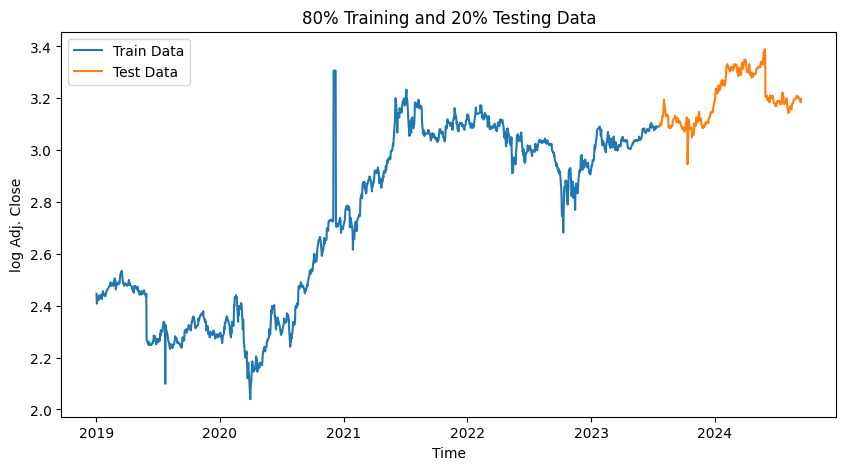

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1141
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2279.579
Date:                Sat, 14 Sep 2024   AIC                          -4557.158
Time:                        13:12:24   BIC                          -4552.119
Sample:                             0   HQIC                         -4555.255
                               - 1141                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011   4.78e-06    224.277      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):           1446689.01
Prob(Q):                              0.20   Pr

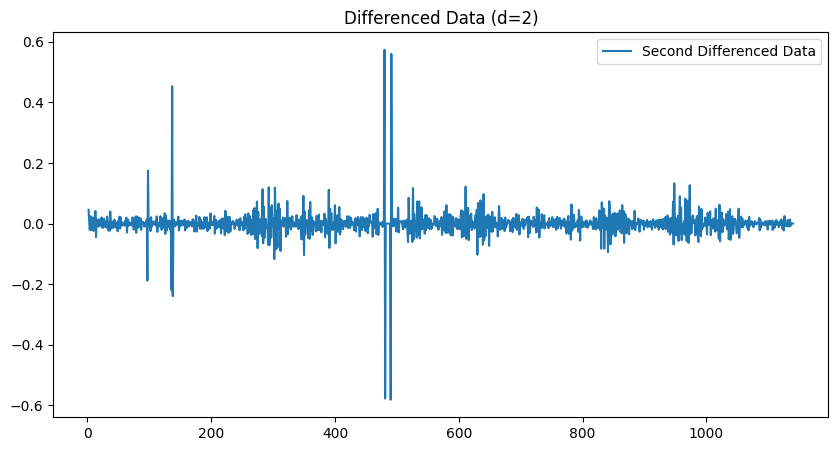

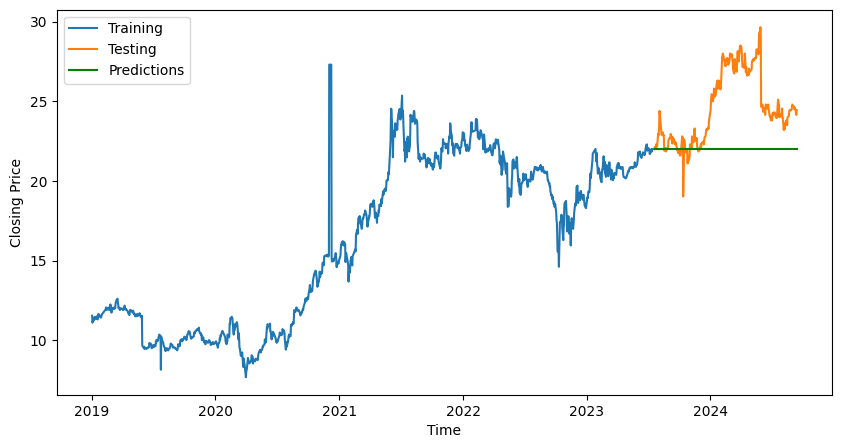

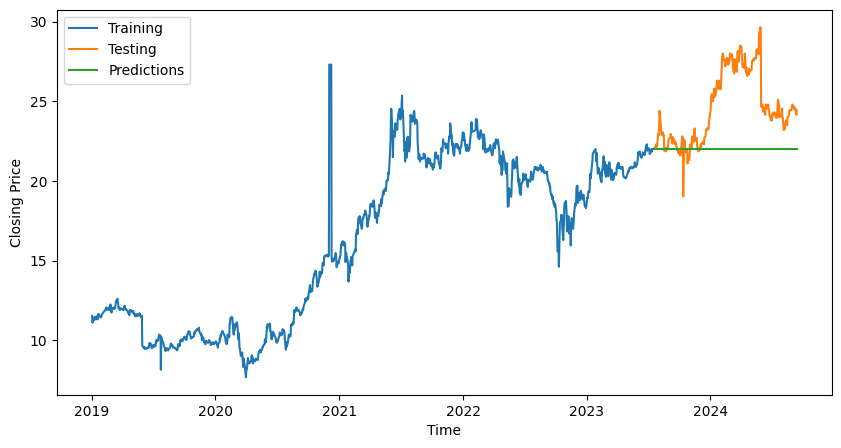

In [116]:
ACB_output = ACB_ARIMA_Model_Fit.forecast(286, alpha=0.05)
ACB_predictions = np.exp(ACB_output)
plt.figure(figsize=(10, 5))
plt.plot(ACB_Train_Data['Date'], ACB_Train_Data['Adj. Close'], label = 'Training')
plt.plot(ACB_Test_Data['Date'], ACB_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(ACB_Test_Data['Date'], ACB_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [111]:
rmse = math.sqrt(mean_squared_error(ACB_Test_Data['Adj. Close'], ACB_predictions))
mape = np.mean(np.abs(ACB_predictions - ACB_Test_Data['Adj. Close'])/np.abs(ACB_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 3.331078795519141
MAPE: nan


#Tesla

In [87]:
BIDV.head()

,Date,Open,High,Low,Adj. Close,Volume
0,2019-01-02 00:00:00,11.703,11.693,11.416,11.544,1103106.0
1,2019-01-03 00:00:00,10.398,11.360,10.267,11.110,1956382.0
2,2019-01-04 00:00:00,11.070,11.413,11.052,11.189,2771983.0
3,2019-01-07 00:00:00,11.426,11.402,11.244,11.347,1305819.0
4,2019-01-08 00:00:00,12.414,12.378,11.235,11.268,846226.0


In [88]:
BIDV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1427 non-null   object 
 1   Open        1427 non-null   float64
 2   High        1427 non-null   float64
 3   Low         1427 non-null   float64
 4   Adj. Close  1427 non-null   float64
 5   Volume      1427 non-null   float64
dtypes: float64(5), object(1)
memory usage: 67.0+ KB


In [89]:
# Change Dtype of Date column
BIDV["Date"] = pd.to_datetime(BIDV["Date"])

In [90]:
Test_Stationarity(BIDV)

Results of Dickey Fuller Test
Test Statistics: -1.336210763429011
p-value: 0.6124473967936362
Number of lags used: 10
Number of observations used: 1416
critical value (1%): -3.434976549531161
critical value (5%): -2.86358329808087
critical value (10%): -2.5678578416363433


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

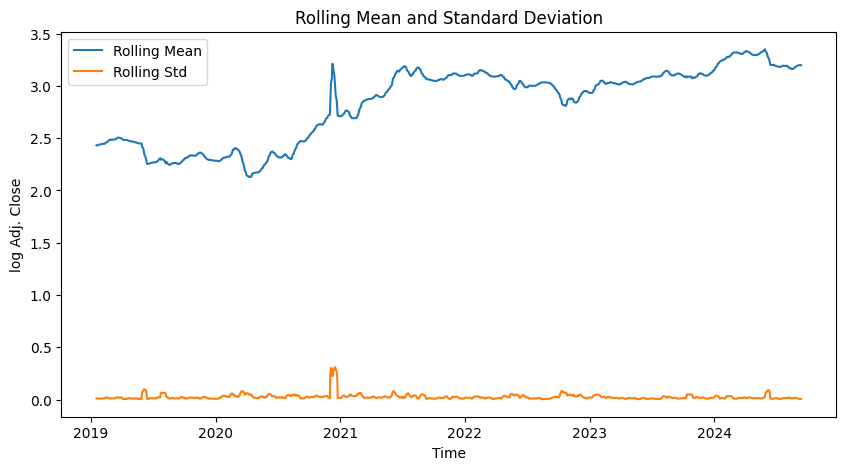

In [91]:
BIDV['log Adj. Close'] = np.log(BIDV['Adj. Close'])
BIDV_log_moving_avg = BIDV['log Adj. Close'].rolling(12).mean()
BIDV_log_std = BIDV['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(BIDV['Date'], BIDV_log_moving_avg, label = "Rolling Mean")
plt.plot(BIDV['Date'], BIDV_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

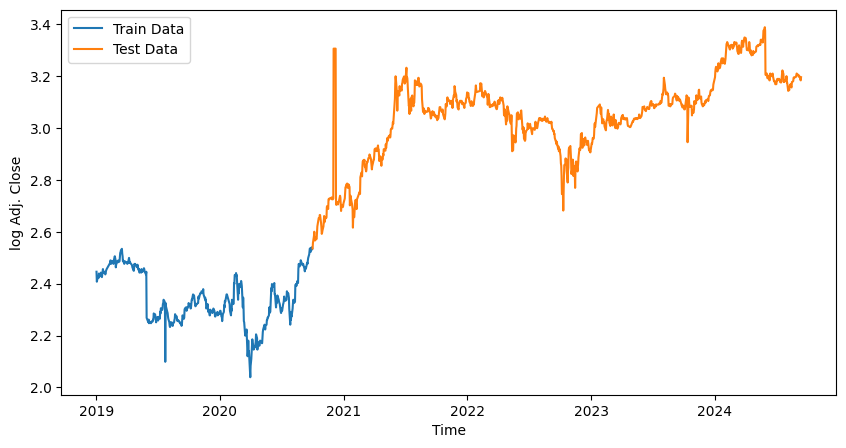

In [92]:
BIDV_Train_Data = BIDV[BIDV['Date'] < '2020-10-01']
BIDV_Test_Data = BIDV[BIDV['Date'] >= '2020-10-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(BIDV_Train_Data['Date'], BIDV_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(BIDV_Test_Data['Date'], BIDV_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [93]:
BIDV_Auto_ARIMA_Model = auto_arima(BIDV_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(BIDV_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  436
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 991.305
Date:                Sat, 14 Sep 2024   AIC                          -1978.611
Time:                        12:52:30   BIC                          -1970.460
Sample:                             0   HQIC                         -1975.394
                                - 436                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2349      0.016    -15.009      0.000      -0.266      -0.204
sigma2         0.0006   1.15e-05     53.246      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [94]:
BIDV_ARIMA_Model = ARIMA(BIDV_Train_Data['log Adj. Close'], order = (5, 2, 2))
BIDV_ARIMA_Model_Fit = BIDV_ARIMA_Model.fit()
print(BIDV_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                  436
Model:                 ARIMA(5, 2, 2)   Log Likelihood                 983.133
Date:                Sat, 14 Sep 2024   AIC                          -1950.266
Time:                        12:52:31   BIC                          -1917.681
Sample:                             0   HQIC                         -1937.404
                                - 436                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9794      1.066     -0.919      0.358      -3.068       1.109
ar.L2         -0.1821      0.203     -0.897      0.370      -0.580       0.216
ar.L3         -0.0253      0.088     -0.287      0.7

###Predicting the closing stock price of Tesla

ValueError: x and y must have same first dimension, but have shapes (991,) and (102,)

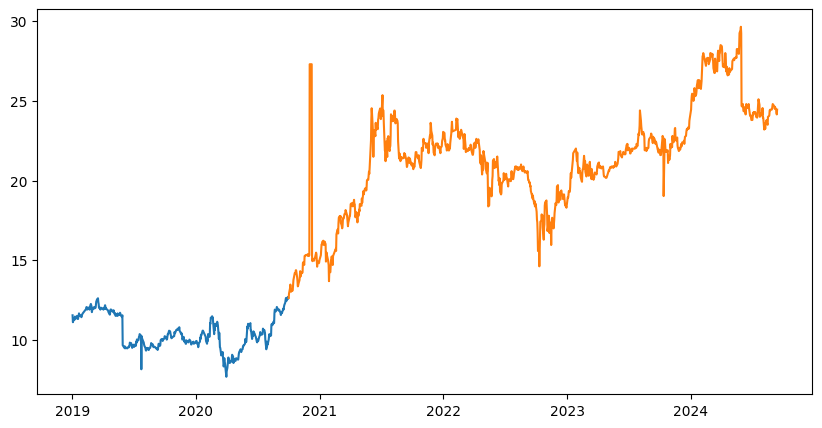

In [95]:
BIDV_output = BIDV_ARIMA_Model_Fit.forecast(102, alpha=0.05)
BIDV_predictions = np.exp(BIDV_output)
plt.figure(figsize=(10, 5))
plt.plot(BIDV_Train_Data['Date'], BIDV_Train_Data['Adj. Close'], label = 'Training')
plt.plot(BIDV_Test_Data['Date'], BIDV_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(BIDV_Test_Data['Date'], BIDV_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(BIDV_Test_Data['Adj. Close'], BIDV_predictions))
mape = np.mean(np.abs(BIDV_predictions - BIDV_Test_Data['Adj. Close'])/np.abs(BIDV_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

#BVHle

In [ ]:
BVH.head()

In [ ]:
BVH.info()

In [98]:
# Change Dtype of Date column
BVH["Date"] = pd.to_datetime(BVH["Date"])

In [ ]:
Test_Stationarity(BVH)

The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

In [ ]:
BVH['log Adj. Close'] = np.log(BVH['Adj. Close'])
BVH_log_moving_avg = BVH['log Adj. Close'].rolling(12).mean()
BVH_log_std = BVH['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(BVH['Date'], BVH_log_moving_avg, label = "Rolling Mean")
plt.plot(BVH['Date'], BVH_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [ ]:
BVH_Train_Data = BVH[BVH['Date'] < '2020-11-01']
BVH_Test_Data = BVH[BVH['Date'] >= '2020-11-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(BVH_Train_Data['Date'], BVH_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(BVH_Test_Data['Date'], BVH_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [ ]:
BVH_Auto_ARIMA_Model = auto_arima(BVH_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(BVH_Auto_ARIMA_Model.summary())

In [ ]:
BVH_ARIMA_Model = ARIMA(BVH_Train_Data['log Adj. Close'], order = (1, 1, 0))
BVH_ARIMA_Model_Fit = BVH_ARIMA_Model.fit()
print(BVH_ARIMA_Model_Fit.summary())

###Predicting the closing stock price of BVHle

In [ ]:
BVH_output = BVH_ARIMA_Model_Fit.forecast(80, alpha=0.05)
BVH_predictions = np.exp(BVH_output[0])
plt.figure(figsize=(10, 5))
plt.plot(BVH_Train_Data['Date'], BVH_Train_Data['Adj. Close'], label = 'Training')
plt.plot(BVH_Test_Data['Date'], BVH_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(BVH_Test_Data['Date'], BVH_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(BVH_Test_Data['Adj. Close'], BVH_predictions))
mape = np.mean(np.abs(BVH_predictions - BVH_Test_Data['Adj. Close'])/np.abs(BVH_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

#Microsoft

In [ ]:
CTG.head()

In [ ]:
CTG.info()

In [114]:
# Change Dtype of Date column
CTG["Date"] = pd.to_datetime(CTG["Date"])

In [ ]:
Test_Stationarity(CTG)

The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

In [ ]:
CTG['log Adj. Close'] = np.log(CTG['Adj. Close'])
CTG_log_moving_avg = CTG['log Adj. Close'].rolling(12).mean()
CTG_log_std = CTG['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(CTG['Date'], CTG_log_moving_avg, label = "Rolling Mean")
plt.plot(CTG['Date'], CTG_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [ ]:
CTG_Train_Data = CTG[CTG['Date'] < '2020-10-01']
CTG_Test_Data = CTG[CTG['Date'] >= '2020-10-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(CTG_Train_Data['Date'], CTG_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(CTG_Test_Data['Date'], CTG_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [ ]:
CTG_Auto_ARIMA_Model = auto_arima(CTG_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(CTG_Auto_ARIMA_Model.summary())

In [ ]:
CTG_ARIMA_Model = ARIMA(CTG_Train_Data['log Adj. Close'], order = (1, 1, 0))
CTG_ARIMA_Model_Fit = CTG_ARIMA_Model.fit()
print(CTG_ARIMA_Model_Fit.summary())

###Predicting the closing stock price of Microsoft

In [ ]:
CTG_output = CTG_ARIMA_Model_Fit.forecast(102, alpha=0.05)
CTG_predictions = np.exp(CTG_output)
plt.figure(figsize=(10, 5))
plt.plot(CTG_Train_Data['Date'], CTG_Train_Data['Adj. Close'], label = 'Training')
plt.plot(CTG_Test_Data['Date'], CTG_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(CTG_Test_Data['Date'], CTG_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(CTG_Test_Data['Adj. Close'], CTG_predictions))
mape = np.mean(np.abs(CTG_predictions - CTG_Test_Data['Adj. Close'])/np.abs(CTG_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

#Amazon

In [ ]:
FPT.head()

In [ ]:
FPT.info()

In [125]:
# Change Dtype of Date column
FPT["Date"] = pd.to_datetime(FPT["Date"])

In [ ]:
Test_Stationarity(FPT)

The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

In [ ]:
FPT['log Adj. Close'] = np.log(FPT['Adj. Close'])
FPT_log_moving_avg = FPT['log Adj. Close'].rolling(12).mean()
FPT_log_std = FPT['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(FPT['Date'], FPT_log_moving_avg, label = "Rolling Mean")
plt.plot(FPT['Date'], FPT_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [ ]:
FPT_Train_Data = FPT[FPT['Date'] < '2020-11-01']
FPT_Test_Data = FPT[FPT['Date'] >= '2020-11-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(FPT_Train_Data['Date'], FPT_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(FPT_Test_Data['Date'], FPT_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [ ]:
FPT_Auto_ARIMA_Model = auto_arima(FPT_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(FPT_Auto_ARIMA_Model.summary())

In [ ]:
FPT_ARIMA_Model = ARIMA(FPT_Train_Data['log Adj. Close'], order = (0, 1, 0))
FPT_ARIMA_Model_Fit = FPT_ARIMA_Model.fit()
print(FPT_ARIMA_Model_Fit.summary())

###Predicting the closing stock price of Amazon

In [ ]:
FPT_output = FPT_ARIMA_Model_Fit.forecast(80, alpha=0.05)
FPT_predictions = np.exp(FPT_output)
plt.figure(figsize=(10, 5))
plt.plot(FPT_Train_Data['Date'], FPT_Train_Data['Adj. Close'], label = 'Training')
plt.plot(FPT_Test_Data['Date'], FPT_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(FPT_Test_Data['Date'], FPT_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(FPT_Test_Data['Adj. Close'], FPT_predictions))
mape = np.mean(np.abs(FPT_predictions - FPT_Test_Data['Adj. Close'])/np.abs(FPT_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')